# S2-regrid-export-workflow

**Date:** <br>
10 November 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

In [2]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [3]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
%config Completer.use_jedi = False

In [4]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Spin up cluster with `dask-jobqueue` 
*----*<br>

### Specs for an individual worker

In [5]:
walltime = '04:00:00'
cores = 8
memory = '32GB'

cluster = PBSCluster(processes = 1, walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-P xv83','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/ux62+gdata/xv83'],
                     header_skip=["select"])

### Scale up to n workers

In [6]:
cluster.scale(jobs=10)

In [7]:
client = Client(cluster)

In [10]:
client

Client Scheduler: tcp://10.6.72.29:37469 Dashboard: http://10.6.72.29:8787/status,Cluster Workers: 5 Cores: 40 Memory: 160.00 GB


In [11]:
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'latt_bounds' in ds.data_vars:
        ds = ds.drop(['latt_bounds'])
    if 'lont_bounds' in ds.data_vars:
        ds = ds.drop(['lont_bounds'])    
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])
    if 'deptht_bounds' in ds.data_vars:
        ds = ds.drop(['deptht_bounds'])
    if 'areat' in ds.data_vars:
        ds = ds.drop(['areat'])        
    return ds

# SST, SSS, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [12]:
%%time
ds_SST_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2020.nc'

In [13]:
%%time
ds_SSS_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_2020.nc'

In [14]:
%%time
ds_mld1_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_2019.nc'

In [15]:
%%time
ds_mld2_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_2020.nc'

In [16]:
%%time
ds_D20_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_2020.nc'

In [14]:
%%time
ds_hc300_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 3.06 s, sys: 1.2 s, total: 4.26 s
Wall time: 9.38 s


In [15]:
%%time
ds_td_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 2.91 s, sys: 1.18 s, total: 4.08 s
Wall time: 8.73 s


In [16]:
%%time
ds_temp_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 3.1 s, sys: 1.17 s, total: 4.27 s
Wall time: 10.3 s


In [17]:
ds_temp50_1981_2018 = ds_temp_1981_2018.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100_1981_2018 = ds_temp_1981_2018.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200_1981_2018 = ds_temp_1981_2018.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500_1981_2018 = ds_temp_1981_2018.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [18]:
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50_1981_2018.drop('deptht'),
                                  ds_temp100_1981_2018.drop('deptht'),
                                  ds_temp200_1981_2018.drop('deptht'),
                                  ds_temp500_1981_2018.drop('deptht'),
                                  ds_SST_1981_2018.squeeze(),
                                  ds_SSS_1981_2018.squeeze(),
                                  ds_mld1_1981_2018,
                                  ds_mld2_1981_2018,
                                  ds_D20_1981_2018,
                                  ds_hc300_1981_2018,
                                  ds_td_1981_2018
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:       (time_counter: 456, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2018-...
Dimensions without coordinates: x, y
Data variables:
    temp50        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

## add back in key metadata

In [19]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [20]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:       (time_counter: 456, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2018-...
Dimensions without coordinates: x, y
Data variables:
    areat         (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    temp50        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

# Deal with the same depth coordinates given two different names & rename time

In [21]:
#ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'deptht':'depth','time_counter':'time'})
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

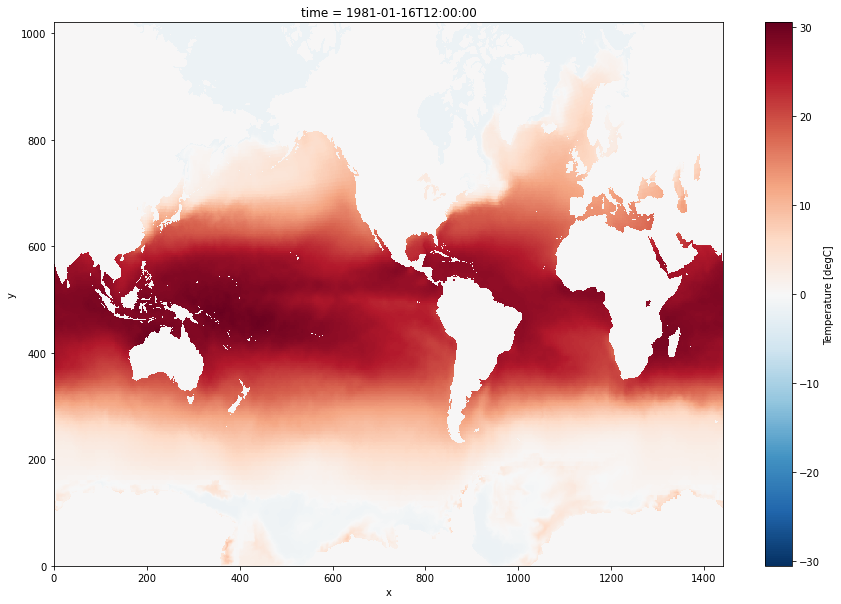

In [91]:
ds_ACCESS_S2_RA_ocean.sst.isel(time=0).plot(size = 10)

In [25]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:  (time: 456, x: 1442, y: 1021)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2018-12-16T12:00:00
Dimensions without coordinates: x, y
Data variables:
    areat    (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    temp50   (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1     (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2     (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300    (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td       (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

In [26]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

29.55753708

# SAVE ocean tgrid zarr file

In [29]:
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [8]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 708 ms, sys: 149 ms, total: 857 ms
Wall time: 5.8 s


Text(0.5, 1.0, 'mld1')

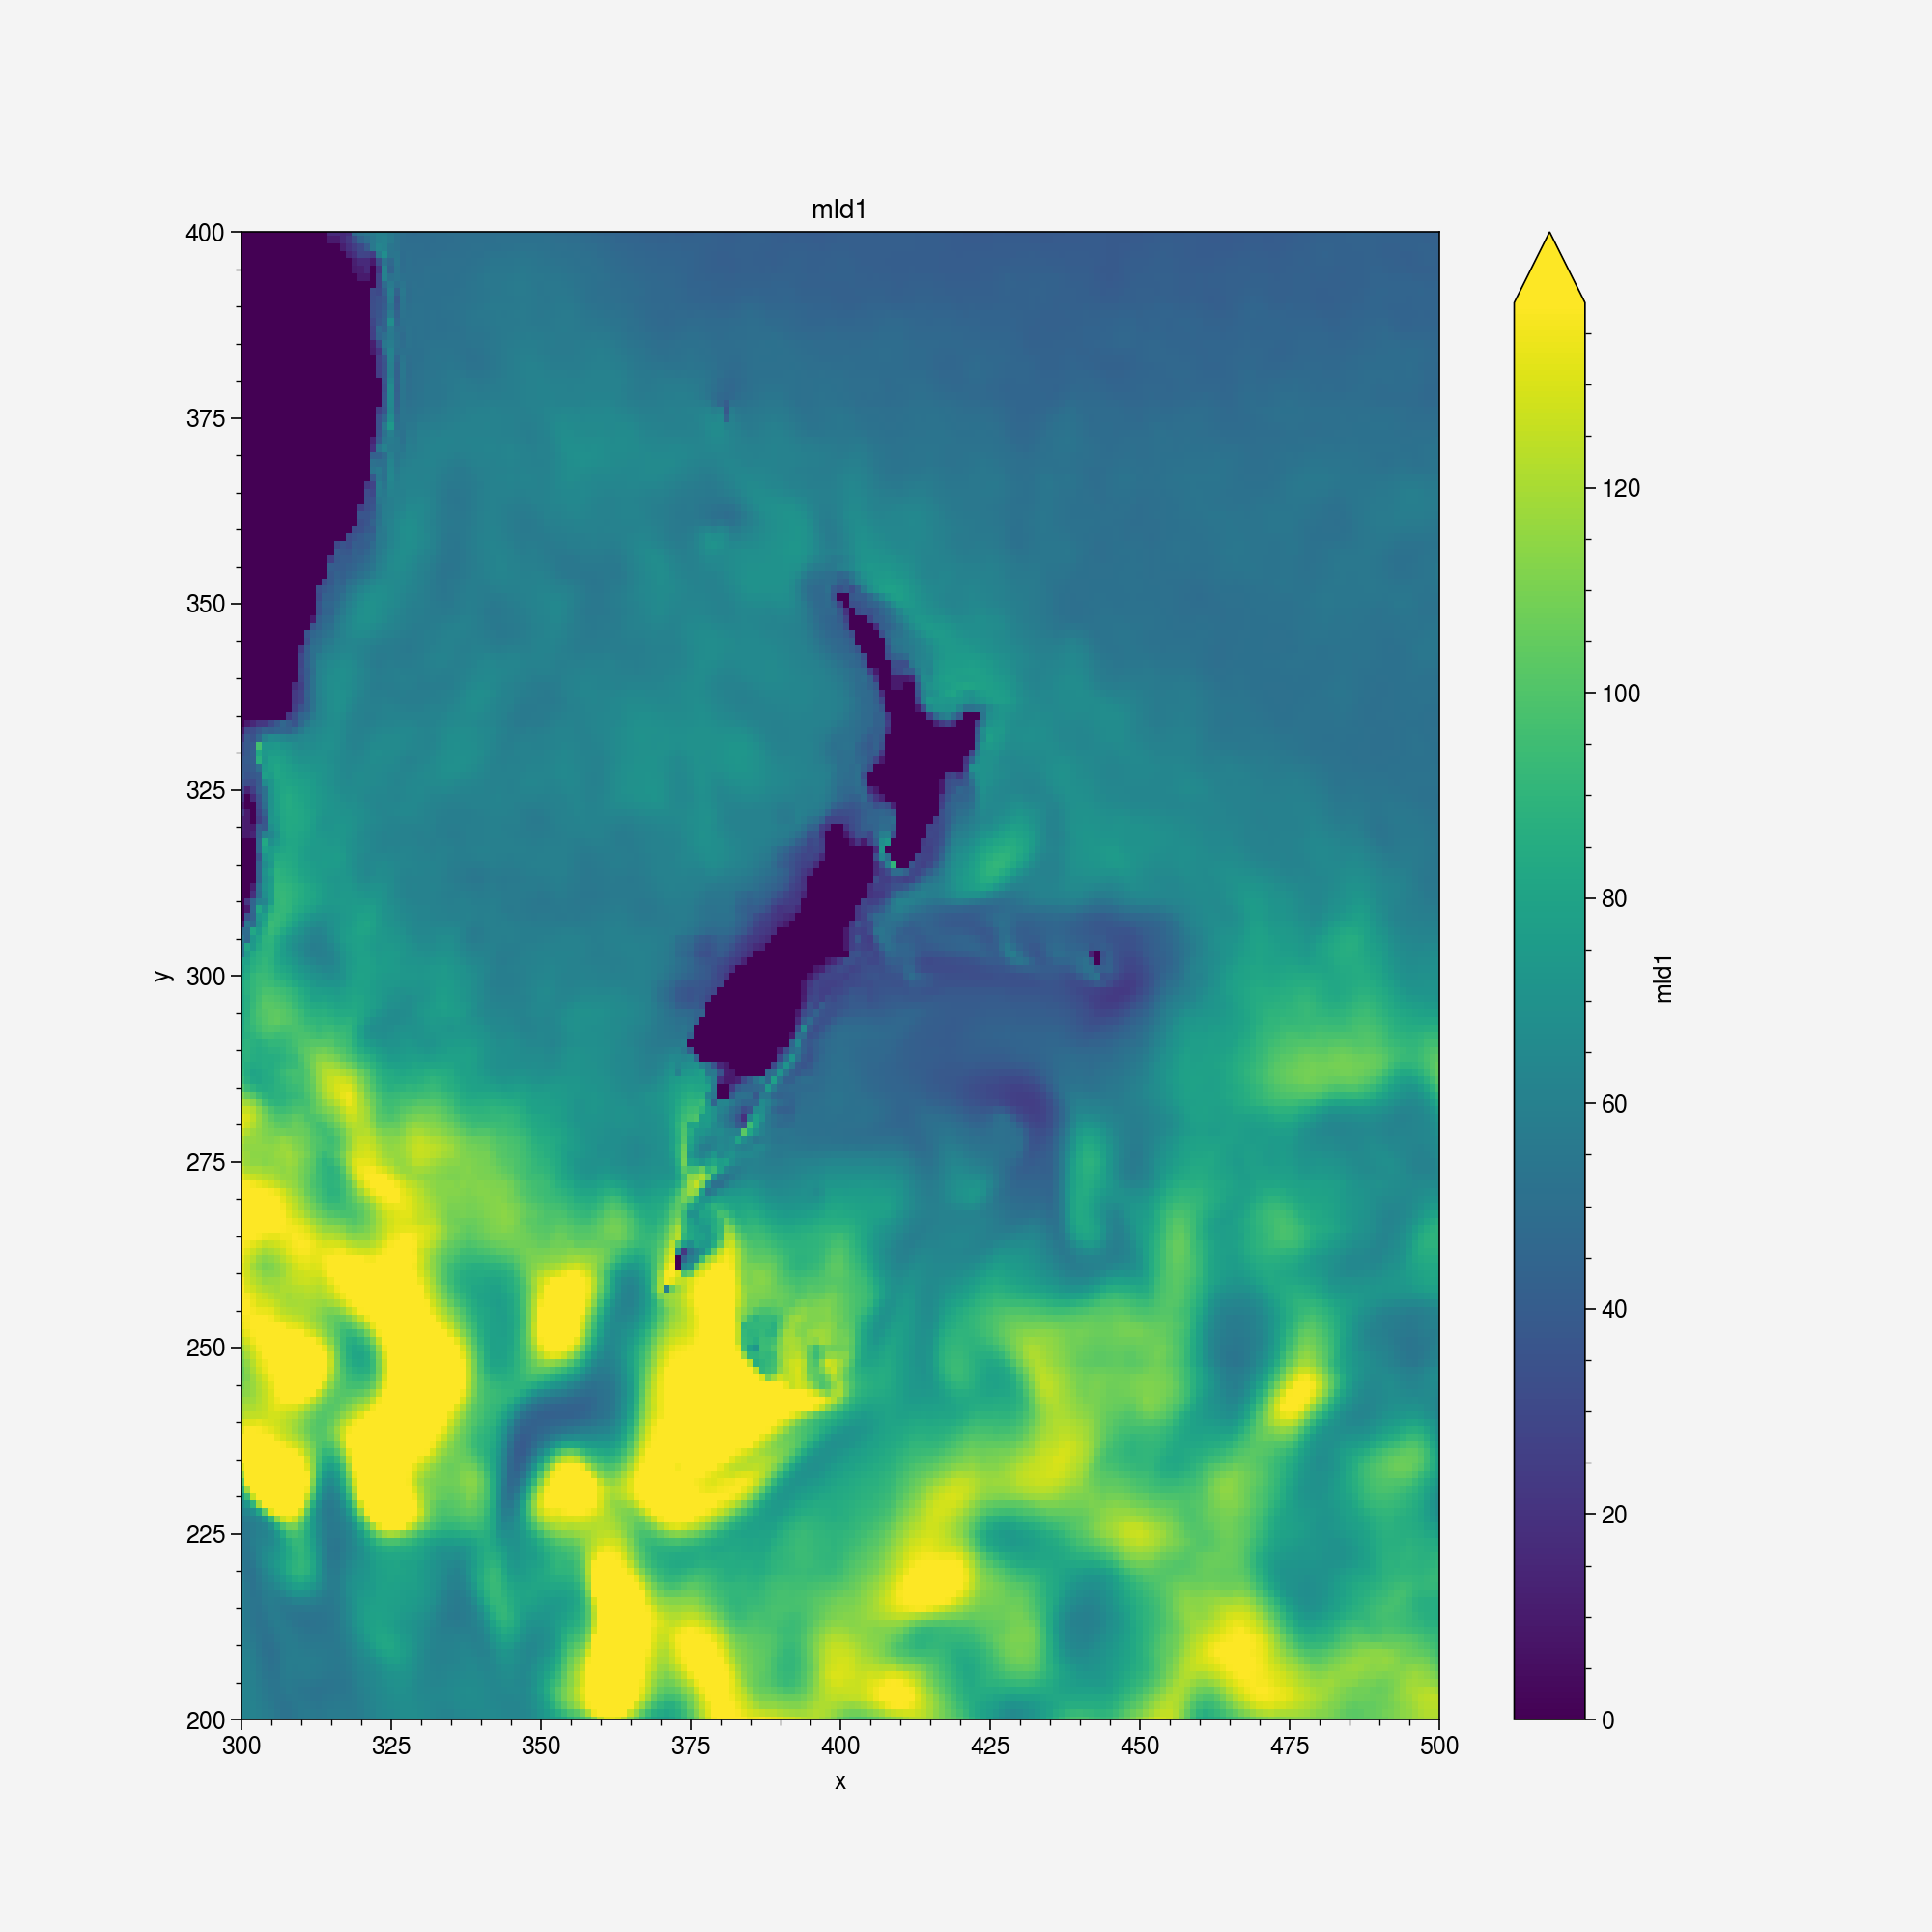

In [10]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('mld1')

# memory // 16GB plus 160GB on cluster

In [9]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

29.55753708

#### let's not persist this given crash on write
ds_ACCESS_S2_RA_ocean_nativeTgrid = ds_ACCESS_S2_RA_ocean_nativeTgrid.persist()

# Regridding Step

## curvilinear grid

In [10]:
nav_lon = ds_ACCESS_S2_RA_ocean_nativeTgrid['lon'].compute()
nav_lat = ds_ACCESS_S2_RA_ocean_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid')

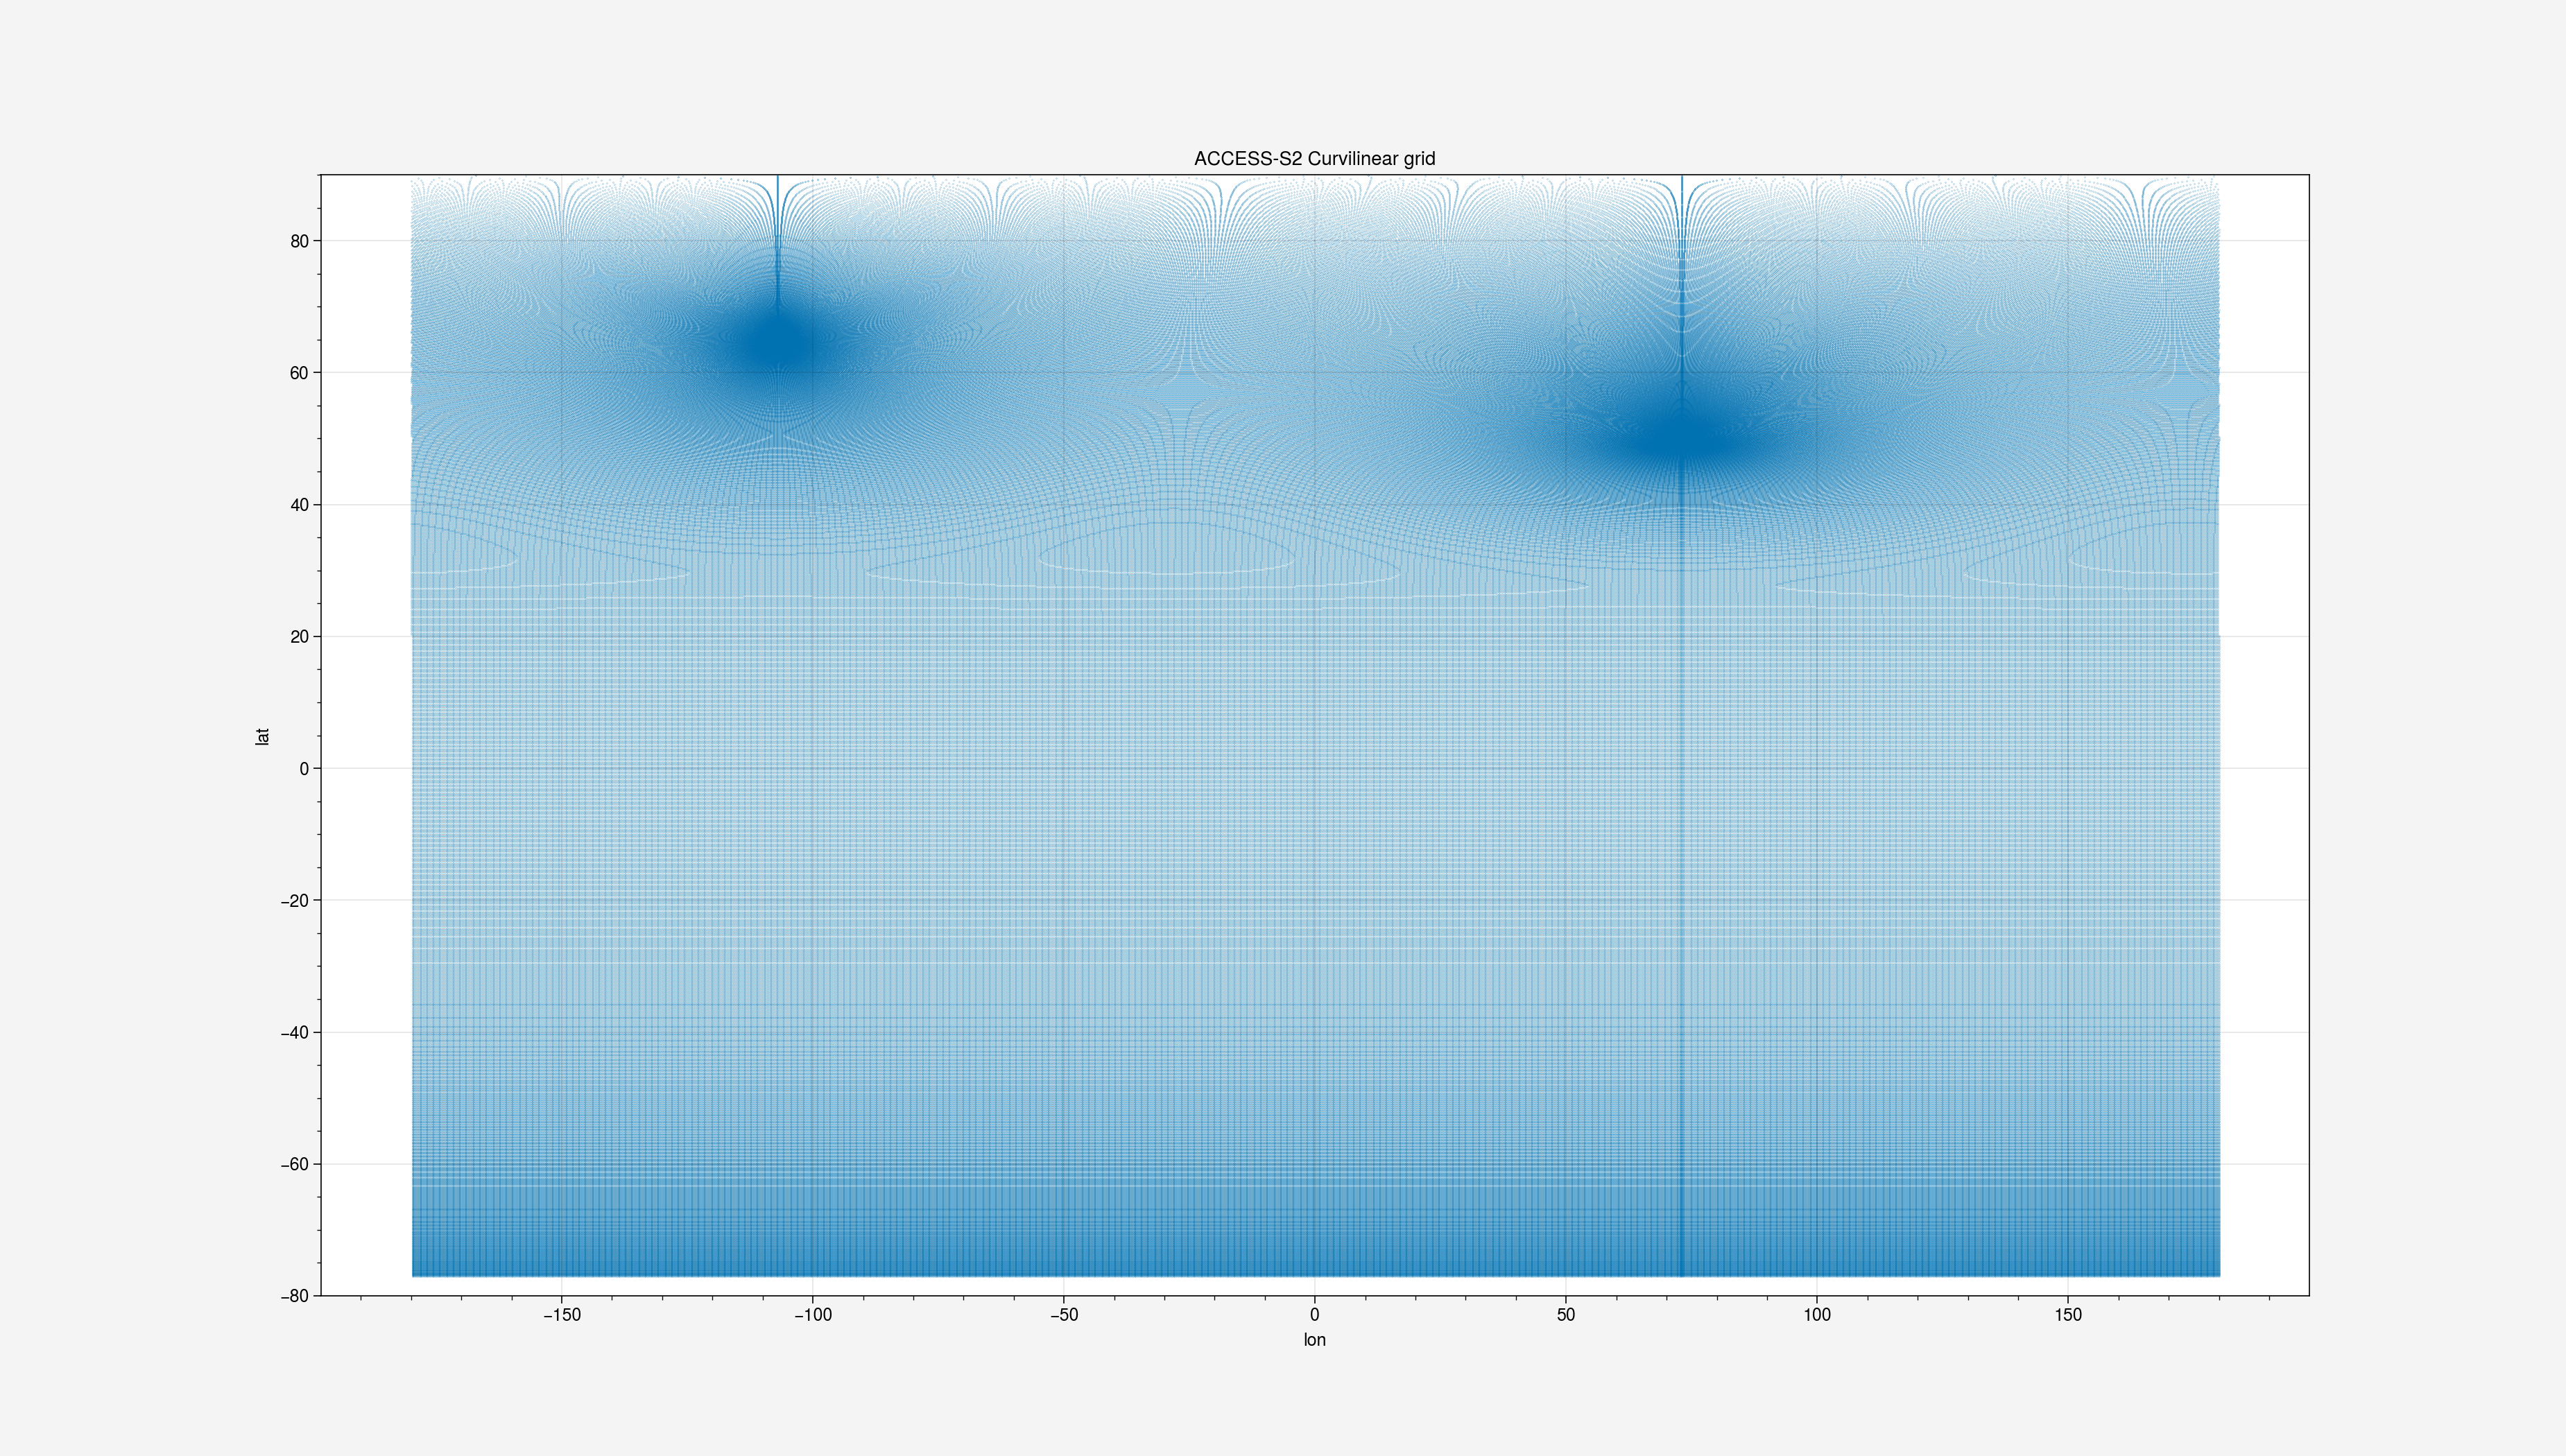

In [11]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [12]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

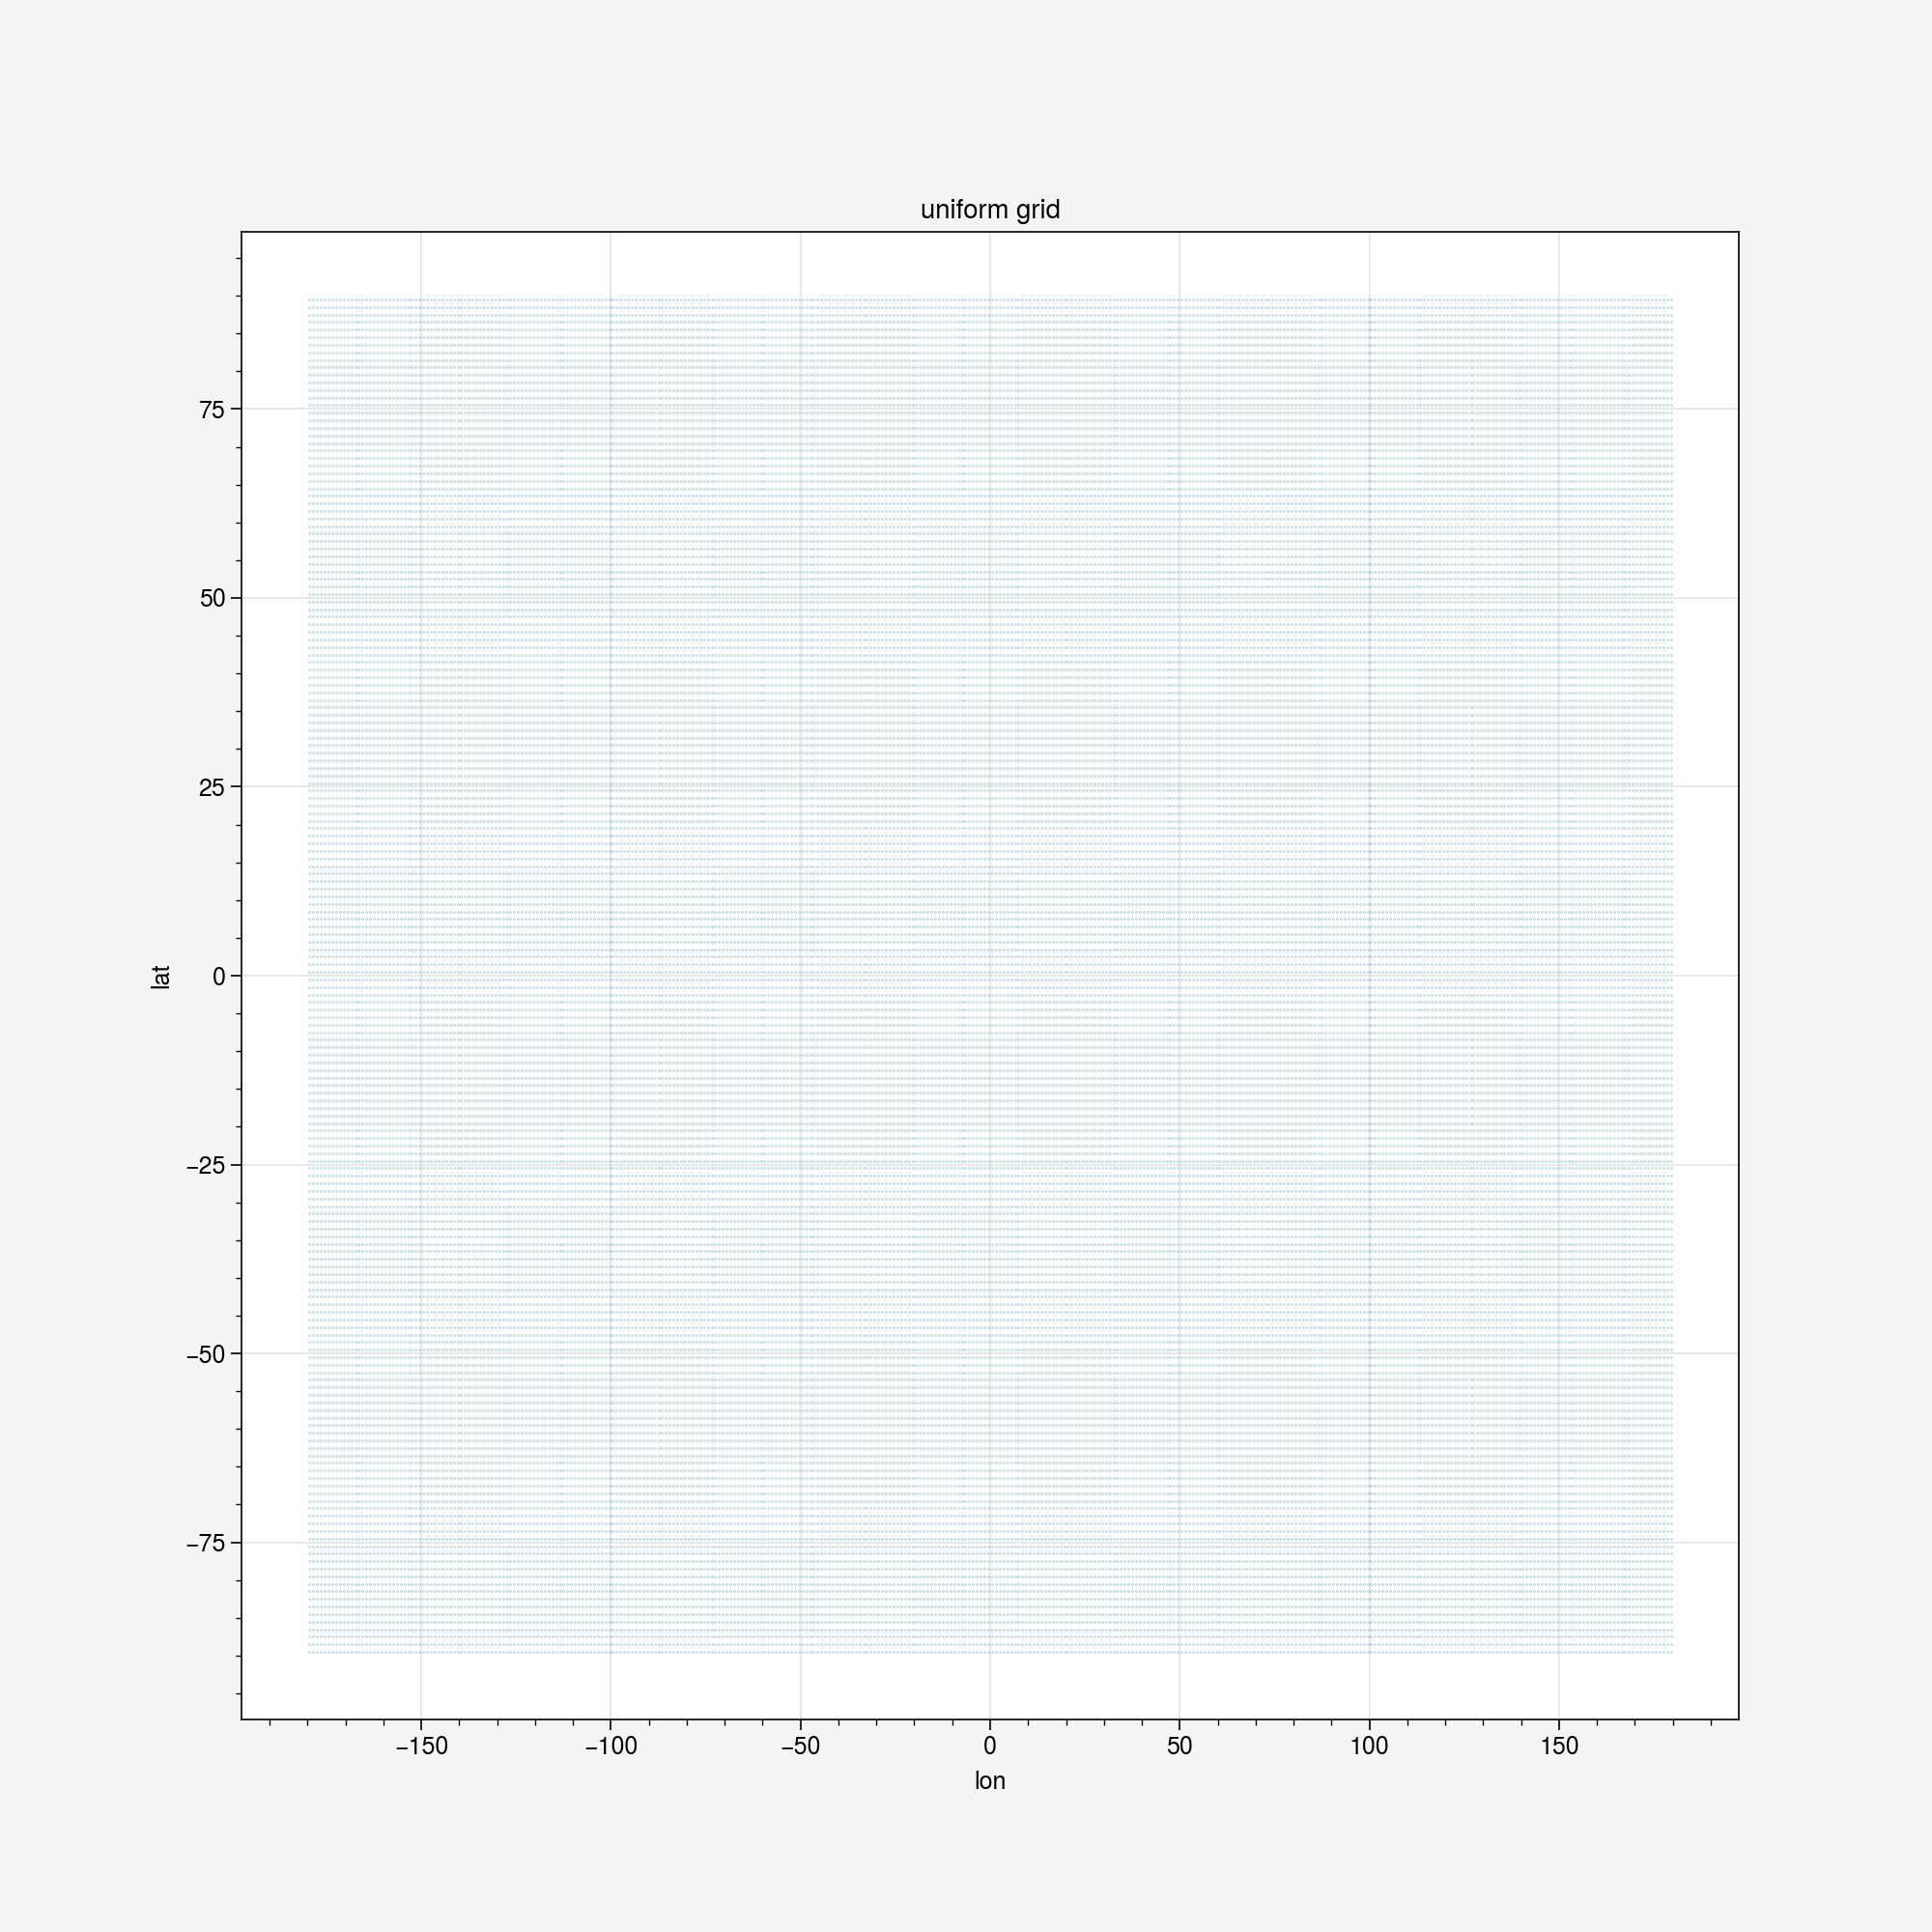

In [13]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [16]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_ACCESS_S2_RA_ocean_nativeTgrid, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

Overwrite existing file: bilinear_1021x1442_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 38.1 s, sys: 3.6 s, total: 41.7 s
Wall time: 40.2 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [17]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_1degRegrid = regridder_S2_1deg_Tgrid(ds_ACCESS_S2_RA_ocean_nativeTgrid)

using dimensions ('y', 'x') from data variable areat as the horizontal dimensions for this dataset.
CPU times: user 43.9 s, sys: 699 ms, total: 44.6 s
Wall time: 43.5 s


In [18]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (time: 456, x: 360, y: 180)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2018-12-16T12:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    areat    (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, y, x) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [19]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [20]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

2.600820768

## Sanity check

In [21]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

CPU times: user 19.9 s, sys: 5.19 s, total: 25 s
Wall time: 3min 49s


CPU times: user 92.4 ms, sys: 3.94 ms, total: 96.3 ms
Wall time: 88.8 ms


(36.0, 107.0)

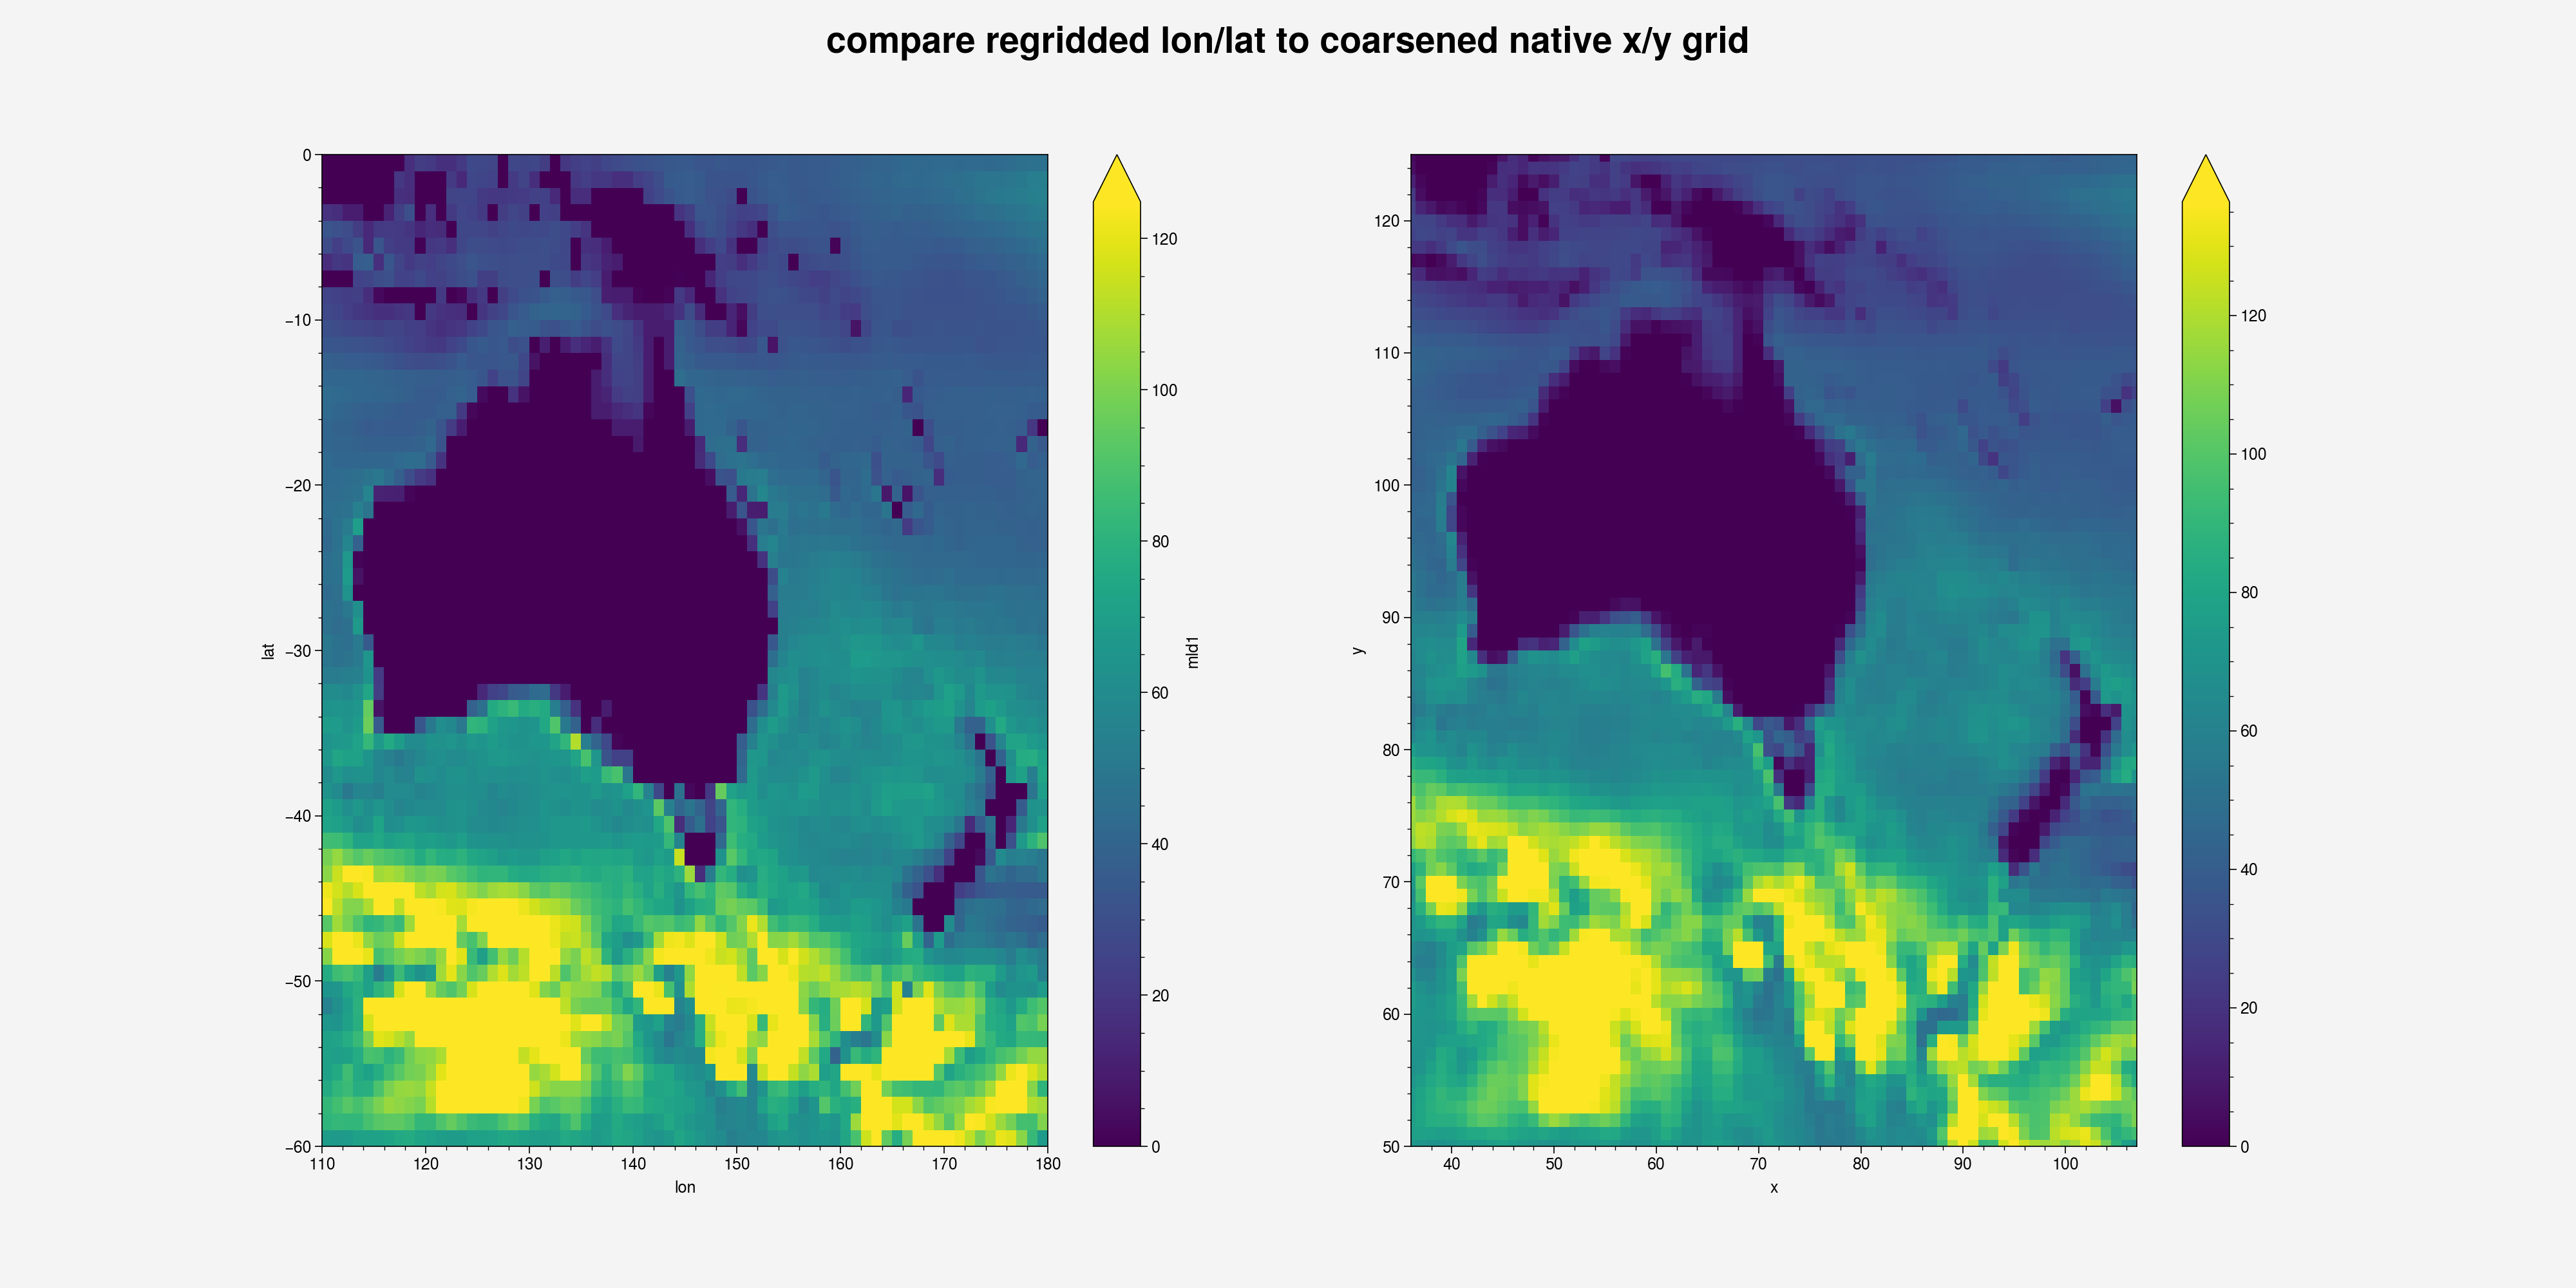

In [23]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [24]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

CPU times: user 28.3 s, sys: 54.1 s, total: 1min 22s
Wall time: 2min 59s


# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [29]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2018

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2019.nc'

In [30]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2018

PermissionError: [Errno 13] Permission denied: b'/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2020.nc'

# Deal with the same depth coordinates given two different names & rename time

In [10]:
ds_u_1981_2018 = ds_u_1981_2018.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2018 = ds_v_1981_2018.rename({'depthv':'depth','time_counter':'time'})

# rechunk the data to shrink chunks from 5GB to 100MB
**could use `rechunker` here?**

In [11]:
u = ds_u_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})
v = ds_v_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})

# write U & V to zarr collections

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr
u.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr
v.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [31]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [13]:
client.restart()

Client Scheduler: tcp://10.6.79.72:34869 Dashboard: http://10.6.79.72:8787/status,Cluster Workers: 32 Cores: 384 Memory: 1.40 TiB


In [17]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [18]:
u_da = u.u
v_da = v.v

In [19]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

CPU times: user 290 ms, sys: 12.5 ms, total: 302 ms
Wall time: 634 ms


In [20]:
KE = xr.merge([EKE,MKE])

In [21]:
KE

,Array,Chunk
Bytes,187.16 GiB,108.48 MiB
Shape,"(455, 75, 1021, 1442)","(455, 1, 250, 250)"
Count,36002 Tasks,2250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,421.22 MiB,244.14 kiB
Shape,"(75, 1021, 1442)","(1, 250, 250)"
Count,22502 Tasks,2250 Chunks
Type,float32,numpy.ndarray


In [46]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

CPU times: user 46.5 s, sys: 2.4 s, total: 48.9 s
Wall time: 2min 4s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [32]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

In [10]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [17]:
KE_surface = KE.isel(depth=0).compute()

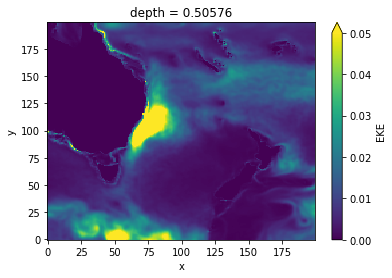

In [20]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

In [21]:
%%time
KE_surface.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE_surface.nc',mode='w')

CPU times: user 99.7 ms, sys: 1.82 s, total: 1.92 s
Wall time: 3.3 s


In [22]:
KE = KE.persist()

In [ ]:
%%time
KE.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nc',mode='w')

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [33]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['OK', 'timed out', 'OK', 'OK', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


Client Scheduler: tcp://10.6.46.34:44925 Dashboard: http://10.6.46.34:8787/status,Cluster Workers: 2 Cores: 8 Memory: 32.00 GB
